In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# Visualize data
def visualize_data(X, y, title=''):
    colors_dict = {0: 'purple', 1: 'yellow'}

    for color in colors_dict.keys():
        idx = np.where(y == color)
        plt.scatter(X[idx, 0], X[idx, 1], c=colors_dict[color], label=color)
    
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
# Generate moons dataset
X, y = make_moons(n_samples=100, noise=0.05, random_state=42)

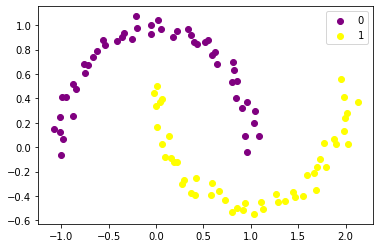

In [4]:
visualize_data(X, y)

In [5]:
def generate_V_matrix(X):
    # max_dims are the upper bounds of each dimension.
    # Since there is not clear specification on which values have to be picked,
    # using the maximum for each dimension should be a good choice
    max_dims = np.max(X, axis=0)

    V = np.array([[np.prod(max_dims - np.maximum(x_i, x_j)) for x_j in X] for x_i in X])

    return V


def lusi_algorithm(X, y, invariant_funcs, use_v_matrix=False, gamma=0.001, rbf_gamma=None):
    n = len(y)

    # Compute V matrix and Gramm matrix
    V = generate_V_matrix(X) if use_v_matrix else np.eye(n)
    K = rbf_kernel(X, gamma=rbf_gamma)

    # Create auxiliar variables
    ones = np.ones(n)
    VK = np.dot(V, K)
    VK_perturbed_inv = np.linalg.inv(VK + gamma * np.eye(n))

    # Compute invariants and store them as columns in a 2D array
    invariant_args = {'X': X, 'y': y}
    invariants = np.array([func(**invariant_args) for func in invariant_funcs]).T

    # Compute vectors
    # A_s is a 2D array whose columns contain the individual A_s_i values
    A_v = np.dot(VK_perturbed_inv, np.dot(V, y))
    A_c = np.dot(VK_perturbed_inv, np.dot(V, ones))
    A_s = np.dot(VK_perturbed_inv, invariants)

    # Create system of equations
    c_1 = np.dot(ones, np.dot(VK, A_c)) - np.dot(ones, np.dot(V, ones))
    mu_1 = np.dot(ones, np.dot(VK, A_s)) - np.dot(ones, invariants)
    rh_1 = np.dot(ones, np.dot(VK, A_v)) - np.dot(ones, np.dot(V, y))

    c_2 = np.dot(A_c, np.dot(K, invariants)) - np.dot(ones, invariants)

    # In order to compute the \mu block, we have to change the order of
    # the operations nad transpose the product of K \times \phi
    K_invariant = np.dot(K, invariants)
    mu_2 = np.dot(K_invariant.T, A_s)
    rh_2 = np.dot(A_v, K_invariant) - np.dot(y, invariants)

    B = np.block([[c_1, mu_1], [c_2.reshape(-1, 1), mu_2]])
    rh = np.hstack([rh_1, rh_2])
    solution = np.linalg.solve(B, rh)

    c, mu = solution[0], solution[1:]
    
    # The sum can be replaced with a dot product
    A = A_v - c * A_c - np.dot(A_s, mu)

    return A, c


def predict(X_train, X_test, A, c, gamma=None):
    # Apply decision rule
    decision = np.dot(A, rbf_kernel(X_train, X_test, gamma=gamma)) + c

    # Get label: if the result of the decision rule is smaller than 0.5, then
    # it's classified as 0. Otherwise, it's classified as 1
    prediction = np.where(decision < 0.5, 0, 1).flatten()

    return prediction

In [6]:
def visualize_decision_boundary(X, A, c, gamma=None, title=''):
    xx,yy = np.meshgrid(np.linspace(-2,3,200),np.linspace(-2,3,200))
    viz=np.c_[xx.ravel(),yy.ravel()]

    z = np.dot(A, rbf_kernel(X, viz, gamma=gamma)) + c

    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7)
    plt.gca().set_xlim([-2.,3.])
    plt.gca().set_ylim([-2.,3.])
    plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-2,3,-2,3),alpha=0.3, vmin=0, vmax=1)
    plt.contour(xx,yy,z.reshape((200,200)))
    plt.contour(xx, yy, z.reshape((200, 200)), levels=[0.5], colors='k')
    
    plt.title(title)
    plt.gcf().set_size_inches((9,9))
    plt.show()

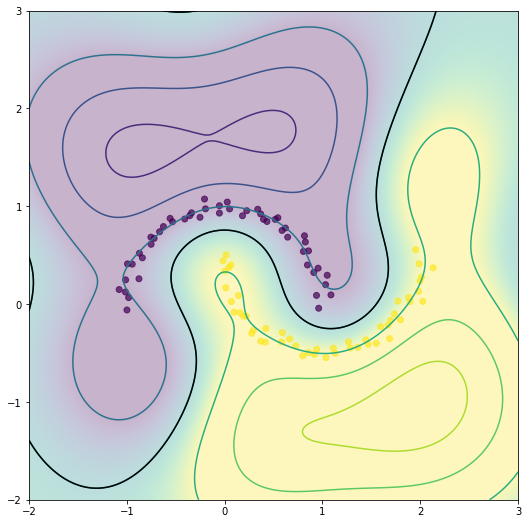

In [7]:
def my_invariant(**kwargs):
    y = kwargs['y']
    return np.ones(len(y))


def my_invariant2(**kwargs):
    X = kwargs['X']
    return X[:, 0]**2 + X[:, 1]**2

A, c = lusi_algorithm(X, y, [my_invariant, my_invariant2], use_v_matrix=True)
visualize_decision_boundary(X, A, c)

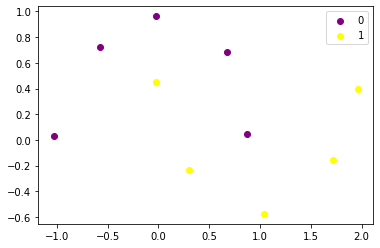

In [8]:
X, y = make_moons(n_samples=10, noise=0.05, random_state=42)
visualize_data(X, y)

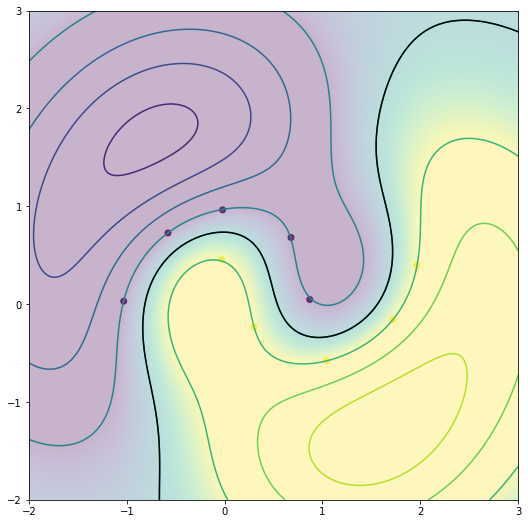

In [9]:
A, c = lusi_algorithm(X, y, [my_invariant, my_invariant2])
visualize_decision_boundary(X, A, c)

## Applying LUSI to the Diabetes dataset

In [10]:
import pandas as pd
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
diabetes_df = pd.read_csv('../data/diabetes.csv')

In [12]:
diabetes_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [13]:
# Get the data and split it in train and test
X, y = diabetes_df.drop('Outcome', axis=1).values, diabetes_df['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=47)

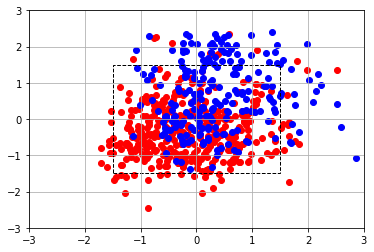

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

plt.scatter(X_train_scaled[y_train==0, 5], X_train_scaled[y_train==0, 1], c='r')
plt.scatter(X_train_scaled[y_train==1, 5], X_train_scaled[y_train==1, 1], c='b')

ax = plt.gca()
rectangle = patches.Rectangle((-1.5, -1.5), 3, 3, color='k', linestyle='--', fill=False)
ax.add_patch(rectangle)

plt.grid()
plt.xlim([-3, 3])
plt.ylim([-3, 3])


plt.show()


In [15]:
def box_invariant(**kwargs):
    X = kwargs['X']
    box_limit = 1.5

    inside_box = np.logical_and(X[:, [1, 5]] >= -box_limit, X[:, [1, 5]] <= box_limit)

    return np.where(inside_box[:, 0] == inside_box[:, 1], 1, 0)

A, c = lusi_algorithm(X_train_scaled, y_train, [box_invariant])

In [16]:
X_test_scaled = scaler.transform(X_test)
y_pred = predict(X_train_scaled, X_test_scaled,  A, c)

len(np.where(y_test == y_pred)[0]) / len(y_test)

0.7142857142857143

In [17]:
A, c = lusi_algorithm(X_train_scaled, y_train, [box_invariant], use_v_matrix=True)
y_pred = predict(X_train_scaled, X_test_scaled,  A, c)

len(np.where(y_test == y_pred)[0]) / len(y_test)

0.6558441558441559